# **🔋 Battery Modelling - EDF R&D 2025**
### **Project Overview**
##### - **Team Members:** Hugo Tran, Etienne Guegan, Akira Kuroda, Tianhe Li
##### - **Goal:** Model battery impedance evolution relative to the battery's age

### **Table of Contents**
##### - Context
##### - Description of approach and models used
##### - Results
##### - References



### **Context**
This project focuses on modelling battery behavior under various ageing conditions. It includes implementations for calculating State of Charge (SoC) and State of Health (SoH) of the cell, along with zero-order and first-order (RC (Resistor-Capacitor)) equivalent circuit models, predicting approximate battery dynamics.



### How to Run the Report Code

#### 1. Necessary imports

In [1]:
# Python modules
import data as dt
import plot as pt

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.integrate import cumulative_trapezoid
import cell_plotting_tests_etienne as et


### <ins>File Structure</ins>

Our code is split into the following modules: \ 
- ***data.py*** regroups all the data manipulation functions needed for the model generation
- ***plot.py*** regroups all plotting function we have elaborated
- ***main.py*** runs a selection of important functions, and can be used for inputing client code


---
## **Description of approach and models used**

We are tasked to simulate the battery cells' behaviour over time, as the cells age.

The following project plan was elaborated:
<br>
**1/** Define what tools are at our disposal
<br>
**2/** Understanding and calculating State of Charge (SoC) and State of Health (SoH)
<br>
**3/** Choosing a model and measuring model parameters
<br>
**4/** Plotting parameters in function of SoC and SoH
<br>
**5/** Error quantification and model improvement

### **1/ What tools are at our disposal?**
Two sets of files, for two different cells: C and D, were available for our analysis. Each file represented a cell **check-up**, recording voltage response to a current input.

One can observe that the given data for cell C and D contains the total time, current, voltage and step. We decided to plot the current, voltage and step in function of the time elapsed.

The ```plot_test(cell, test)``` function, that takes as arguments the cell type ("C" or "D") and the test number ("01" for example) (both in ```String```) allowed us to plot the following:

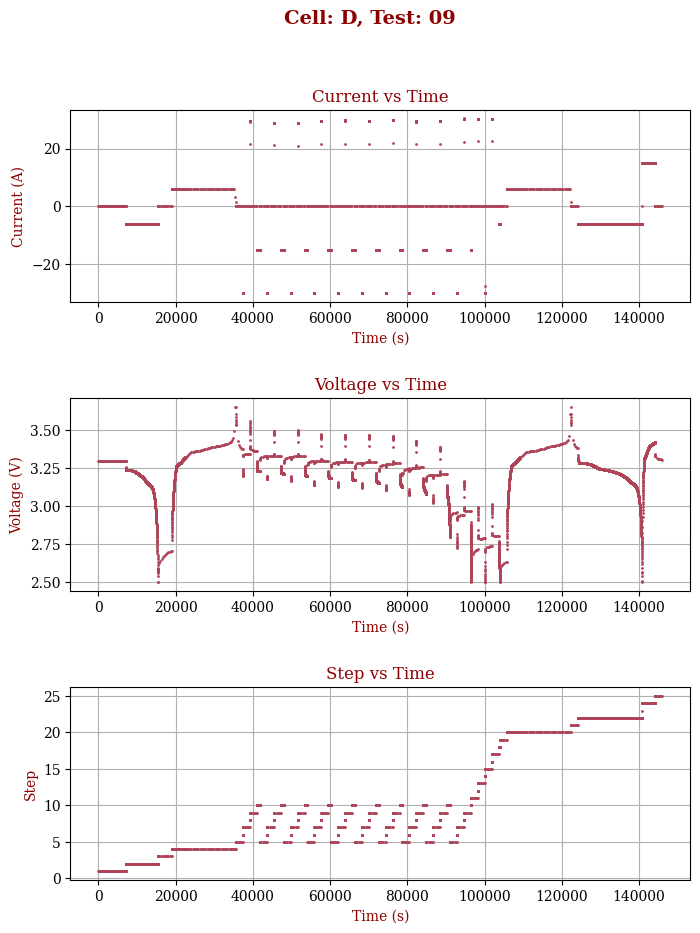

In [2]:
pt.plot_test("D", "09")


2 things are to be noted for our modelling:
- The recorded values are **discrete**, which must be taken into consideration for future parameter measurement.
-  2 important regions can be discerned. In the **pulse region** (around 35000s to 105000s), the current varies quickly, reproducing a similar effect on voltage. In the **discharge region** (from 120000s to 140000s), the battery undergoes a full discharge and voltage progressively goes from maximum value to minimum value.

### **2/ SoC and SoH**

Before looking into these two battery characteristics, it is important to define **capacity**.

The **capacity** of a battery, measured in **Ampere-hours (Ah)**, represents the total charge it can store and deliver.  
With ageing, the available capacity decreases, meaning an older battery can deliver less charge than a new one.

The total capacity for a check-up is calculated as the integral of the **current** cycle over time over a **full discharge**:

$$
Q_{\text{remaining}} = \int_{full \: discharge} I(t) \, dt
$$

where:
- ***$Q_{remaining}$*** is the remaining charge in **Ah**,
- ***I(t)*** is the discharge current at time \( t \).

We plan to calculate the capacity of the battery by measuring the integral of the current over the **full discharge** region of the data. 

<ins>State of charge:</ins>

The **State of Charge (SoC)** of a battery, expressed as a **percentage (%),** represents the available charge relative to its remaining capacity for that check-up. 
It is equivalent to the indicated battery percentage on smartphones.

The SoC at a given time is calculated as the ratio of the available charge over the remaining capacity:

$$
\text{SoC}(t) = \frac{Q_{\text{available(t)}}}{Q_{\text{remaining}}} \times 100
$$

where:  
- ***SoC(t)*** is the **State of Charge** at time \( t \) in **%**,  
- ***$Q_{available}$*** is the available charge in **Ah** of the remaining total,  
- ***$Q_{remaining}$*** is the remaining (rated) capacity of the battery in **Ah**.

$Q_{available}$ at a time t can be found by substracting the total capacity for the check-up ($Q_{remaining}$) and the integral of the current before the time t (the capacity).


<ins>State of health:</ins>

The **State of Health (SoH)** of batteries corresponds to the ratio of the remaining total capacity for a given check-up over the initial total capacity. In other words, it can inform us on how much capacity the battery has lost due to ageing. The SoH is expressed in percentage by the following equation:


$$
SoH [\%] = \frac{Q_{remaining}}{Q_{initial}}
$$

Assuming the battery is not damaged initially and is at full total capacity, we can say that $Q_{initial}$ is total capacity of the battery for the first check-up.





### **3/ Choosing a model and measuring model parameters**

We plan to use an **Equivalent Circuit Thevenin Model** to simulate our battery.

An Equivalent Circuit Model models the dynamics of a battery by an electric circuit.

The Thevenin model uses a specific circuit, composed of a voltage source, a resistance representing the internal resistance of the battery, and n RC loops, for a model of order n.

**Advantages of the model**
The model provides a dynamic and accurate (more or less depending on the order) simulation of the battery while applying simple concepts. The model requires the resolution of 1st year electrical circuit equations to calculate a small number of parameters, therefore previously acquired knowledge may be applied.

Moreover, this model has already been frequently applied to model Lithium Ion batteries, and many research papers can be found concerning it.

**Limits of the model**
One limitation of this model is precision: other models exist with higher accuracy, however they require more calculations.


We plan to use first a 0th order Thevenin model and adapt it into a 1st order Thevenin model. Depending on the accuracy of the 1st order, we may move on to the 2nd order, however we suppose that the increase in the accuracy of the model will be low compared to the increase in calculations needed.


<ins>Model Parameters</ins>

<div align = "center">
<img src = "img/circuit_zero_order.png" alt = "0th order / Rint Model circit" width = "500"/>
</div>

For the **0th order model**, the following equation of $U_L$ can be found:

$$
U_L = U_{OC} - U_0
\implies U_L = U_{OC} - I_L \cdot R_{0}
$$

Two parameters may be identified: open circuit voltage ($U_{OCV}$) and resistance ($R_{0}$).

The open circuit voltage is defined as the voltage of the battery when no current has been applied to it for a sufficiently long amount of time (1 or 2 hours).

This translates graphically (approximately) to finding the voltage of the battery when its current is equal to ```0 Amps```. For instance for cell D test 9, the circled portions of the graphs correspond to its OCV.

<div align = "center">
<img src = "img/finding_ocv.png" alt = "Finding OCV" width = "700"/>
</div>

The resistance $R_{0}$ can be described as the resistance that acts instantly on the battery. Taking inspiration from the resource given, we establish the equation of the internal resistantce $R_0$ by:

$$
R_0 = \frac{U_A - U_B}{I_L}
$$

where $U_A$ and $U_B$ are found graphically. Below is an image of finding the four voltages per pulse.

<br>
<div align = "center">
<img src = "img/find_ua_ub_uc_ud.png" alt = "Finding UA UB UC UD" width = "700"/>
<p>Figure 1: Graph of the voltage during a current pulse. We can determine the voltages at points A, B and C</p>
<p>Source: Ruoyu Xu, "Lithium-ion battery modeling and SoC estimation", 2023 Kth Royal Institute of Technology, </p>
</div>
<br>

By zooming in on our data, we observe that for each current pulse, the voltage follows a similar graph, where $U_A$ and $U_B$ can be extracted. In fact, we will take $U_A$ = $U_{OCV}$.  Below is an example of that of cell D on test 9. We observe that this pattern happens for a current pulse of around ```-30 Amps```.

<div align = "center">
<img src = "img/voltage_cell_d_test_9_49800s.png" alt = "Voltage after a current pulse of -30A" width = "900"/>
</div>


<div align = "center">
<img src = "img/circuit_first_order.png" alt = "1st order / Thevenin Model circit" width = "500"/>
</div>

For the **1st order model**, the following equation can be found:

$$
U_L(t) = U_{OC} - I_L \cdot R_0 - I_L \cdot R_1 \cdot (1 - e^{-\frac{t}{\tau_1}})
$$

Two more parameters can be identified: the RC loop resistance ($R_{1}$) and capacitance ($C_{1}$).

$R_{1}$ acts upon the exponential part of the pulse, and can be calculated as follows:

$$
R_1 = \frac{U_{B} - U_{C}}{I_{L}}
$$

On the other hand, measuring $C_{1}$ on the graph seems improbable. Thus, we will measure $\tau$ as the characteristic time of the loop and deduce the capacitance via $\tau = R_{1}*C_{1}$. Out of many other methods, measuring $\tau$ can be achieved either by finding one third of the time for 95 % of the voltage difference between $U_{B}$ and $U_{C}$ to be reached, or taking the time for 63% of that difference to be reached. We will choose our method by comparing the given model results.

### **4/ Plotting parameters in function of SoC and SoH**

Since our model depends only on the input current, the SoC and the SoH, we must establish a relation between the parameters of the model and the SoC and SoH.

To establish a relation between our parameters and **SoC**, we will measure our parameters for a range of SoC values, and curve fit the data using the Numpy function: ```polyfit()```.

An **SoH** relation can be inferred from knowing which test the model is applied to, since we assume that the SoH does not vary a lot over a check-up.

### **5/ Error quantification and model improvement**

To quantify the error of our model, we can measure the difference in voltage between the real data and the model voltage, or the distance of the two voltages.

To improve our model, we can apply the model to a single impulse, allowing us to test different measurements of parameters, and apply our newly acquired knowledge to our general model.



---
## **Results**




### **SoC and SoH Plots** 

In order to illustrate the plot of the **State of Charge (SoC)** of a given cell, the following function ```plot_soc``` calls our SoC plot function which takes as arguments the specific cell and test wanted:

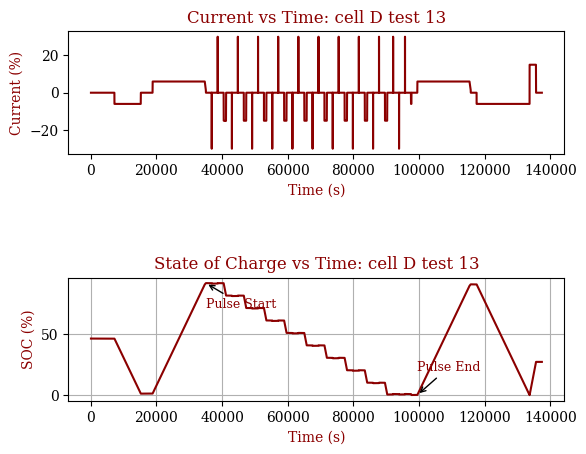

In [3]:
pt.plot_soc("D","13")


**Analysis**

The **State of Charge (SoC) vs. Time graph** shows the charge and discharge behaviour of the a given cell  over the a given test cycle. Initially, the SoC is discharged (15000s) before gradually increasing as the battery is charged.

Once it reaches approximately 100%, the battery undergoes a sequence of **charge and discharge cycles** before eventually reaching a full charge and discharge at the end of the test. 

In the middle of the graph, we observe pulsed discharges, where the **SoC drops sharply** after reaching full charge. This pattern repeats, indicating that the battery is undergoing controlled pulse discharges. The decrease of the SoC in a step curve is expected as the battery is discharged via sudden impulses.

We also observe that the SoC passes from approximately 100% to 0% during the full discharge, which is also expected.


## **State of Health** (SoH)

In order to illustrate the plot of the **State of Health (SoC)** of a given cell, the function ```plot_soh_cell_c_cell_d()``` from the ```plot``` file is called.

We decided to plot the SoH of cells C and D in function of their test value. Cell C has 23 tests, while cell D has 13. For both batteries, we assume maximal state of health for the intial test (00).

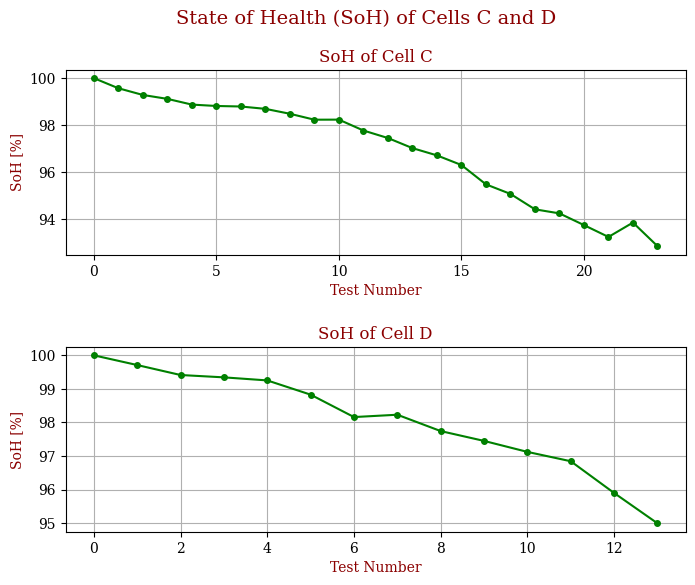

In [4]:
pt.plot_soh_cell_c_cell_d()


**Analysis**

We observe a **decline in SoH as time goes on**, and the battery is exposed to current pulses. This behaviour can be due to the material degradation of the cell, indeed the anode and cathod materials as well as the electrolyte can be subject to damages over time.

We may also note that the **rate of decline of the SoH of the cells increases with time**. Indeed, the last few tests presented a steeper decline compared to that of the first tests. We can hypothesize that the cell's health decreases faster as the battery is used/damaged.

However, we observe certain **unexpected behaviours**, notably for cell C during the 20th to 23rd test. We see a spike in its SoH when we expected a decline. This could be due to the fact that this range of tests was done beforehand / not in a chronological order, or some anomalies and uncertainties in its measurements.

These complex ageing dynamics make it essential for **Battery Management Systems (BMS)** to accurately estimate SoH and manage battery usage efficiently. Accurate SoH estimation not only improves the charging/discharging process but also helps predict battery lifespan and optimize the operation of energy storage systems.

## **ECM parameters as functions of SoC and SoH** 

### **ECM of order zero**

#### Finding $U_{OC}$

Below is the code of the dataframe of cell C on test 9, where we keep the values such that its current is equal to ```-16 Amps```. Although OCV is defined as the voltage when the current is null, we established that measuring the OCV at -16 Amps for cell C was gave more accurate results.

In [5]:
print(dt.soc_ocv("C", "09")) # Dataframe with OCV extracted, and SoC calculated


    Total Time  Current    OCV       SoC
0      16950.0    -16.0  4.101  0.928605
1      16950.1    -16.0  4.101  0.928590
2      17339.6    -16.0  4.041  0.875484
3      17339.7    -16.0  4.041  0.875469
4      17730.2    -16.0  3.983  0.822513
5      17730.3    -16.0  3.983  0.822498
6      18120.8    -16.0  3.926  0.769541
7      18120.9    -16.0  3.926  0.769526
8      18511.4    -16.0  3.869  0.716570
9      18511.5    -16.0  3.869  0.716555
10     18902.0    -16.0  3.811  0.663449
11     18902.1    -16.0  3.811  0.663434
12     19291.6    -16.0  3.755  0.610328
13     19291.7    -16.0  3.755  0.610313
14     19681.2    -16.0  3.713  0.557206
15     19681.3    -16.0  3.713  0.557191
16     20070.8    -16.0  3.680  0.504085
17     20070.9    -16.0  3.680  0.504070
18     20459.4    -16.0  3.654  0.450813
19     20459.5    -16.0  3.654  0.450798
20     20848.0    -16.0  3.630  0.397542
21     20848.1    -16.0  3.630  0.397527
22     21236.6    -16.0  3.612  0.344270
23     21236.7  

However, since we can only measure one OCV per pulse, we only obtain a sample of the OCV. So we can only establish a discrete relationship between the OCV and the SoC (seen above). 

To get its continuous version, we apply curve fitting thanks to the ```np.polyfit``` function.
We developped the ```model_data_soc_ocv_soh``` function, taking into argument either ```"C"``` or ```"D"```, to check the SoC-OCV curve on different SoH levels.

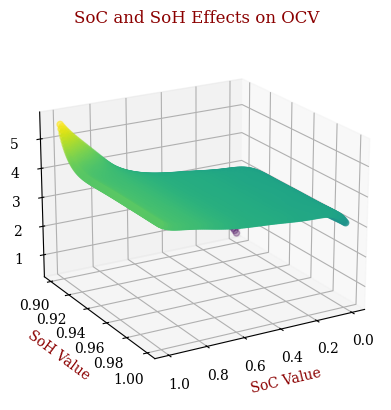

In [6]:
pt.model_data_ocv_soc_soh()
    

**Analysis**

We expect OCV to increase with respect to SoC. The more charged the battery, the higher the voltage it can deliver. This behaviour can be spotted on the initial voltage plots, where OCV decreases as the SOC decreased during the pulse region.

Indeed, this it what we can observe in our plot of the OCV wiht respect to SoC.

#### Finding $R_0$

Similarly to the Open Circuit Voltage, we measured $R_{0}$ for each pulse and paired those values with the measured SoC value, giving a discrete relation between the resistance and the SoC.

To get its continuous version, we apply curve fitting by executing the following code:

In [7]:
soh_value = dt.soh("C","09")
#global soh_value
time_between_dupes = 300
df = dt.extract("C","09")
df["SoC"] = dt.soc("C","09")
df["R0"] = [dt.R0_fit.f(soc_value,soh_value) for soc_value in  df["SoC"]]
print(df)



      Total Time  Current  Voltage  Step       SoC        R0
0            3.4    0.000    3.504     1  0.095911  0.002274
1           60.0    0.005    3.505     1  0.095912  0.002274
2          120.0    0.005    3.506     1  0.095915  0.002274
3          180.0    0.005    3.506     1  0.095918  0.002274
4          240.0    0.000    3.506     1  0.095919  0.002274
...          ...      ...      ...   ...       ...       ...
8041     40909.8  -16.000    3.001    27  0.004216  0.002934
8042     40910.2  -16.000    3.000    27  0.004156  0.002934
8043     40920.2    0.000    3.065    28  0.003405  0.002943
8044     40930.2    0.000    3.072    28  0.003405  0.002943
8045     40940.2    0.000    3.077    28  0.003405  0.002943

[8046 rows x 6 columns]


The following graph of $R_{0}$ with respect to SoC and SoH can be found below:

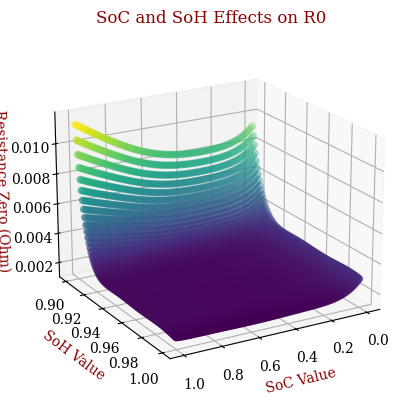

In [8]:
pt.model_data_r0_soc_soh()

**Analysis**

We expect the battery to be less performant as SoC and SoH decrease. Thus the resistance should decrease when SoC and SoH increase.

This is not exactly what can be concluded from the graph. Although we do see that the overall resistance decreases with respect to SoH, the resistance makes a **V-shaped curve with respect to SoC**. This could be due to certain **overcharging or undercharging behaviours**, and would imply that charging or depleting the battery past a certain point could lead to considerable decreases in battery performance.

### **0th order model results**

Knowing the two variables, we get the following simulation for the output voltage:

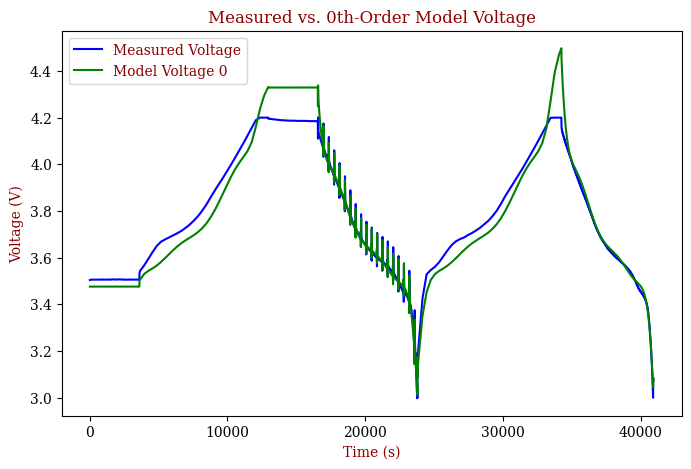

In [9]:
pt.plot_simultaneous_0("C", "09")


**Analysis**

We can observe some anomalies before the pulse region and before the full discharge, which could be due to our fitting function. Since R0 and OCV are not calculated outside of the pulse region, we are solely relying on our curve fitting for these areas of the plot.

During one impulse, we can observe that the model correctly predicts the instant reaction of the resistance $R_{0}$, but exhibits a plateau where the predicted data exhibits exponential behaviour. This is expected, as the 0th order model does not deal with the dynamic response of the battery.

We can also observe a slight shift between the measured and predicted Open Circuit Voltages. 

## **First order ECM**

#### Finding $R_1$

The same approach as the other variables is applied to $R_{1}$, where the formula used is described in the approach part of the report. 

The following measurements of R1 were obtained:

Plotting R1 as a function of SoC and SoH gives the following graph:

**Analysis**



#### Finding $\tau_1$


<div align = "center">
<img src = "img/find_tau.png" alt = "Image describing how to find tau" width = "900"/>
</div>

The following values of tau can be measured:

We apply curve fitting for a continuous relationship between $\tau_1$ and SoC.

Using this, we may plot $C_{1}$ as a function of SoC and SoH:

**Analysis**

### **1st order model results**

The following plot can be obtained from our 1st order model:

r1       Total Time  Current  Voltage  Step       SoC        R0       OCV  \
120      16968.3    -32.0    4.128     7  0.982137  0.001839  4.360579   
121      16969.3    -32.0    4.126     7  0.981841  0.001839  4.358313   
122      16970.3    -32.0    4.124     7  0.981544  0.001839  4.356060   
123      16971.3    -32.0    4.122     7  0.981248  0.001839  4.353820   
124      16972.3    -32.0    4.121     7  0.980952  0.001838  4.351592   
...          ...      ...      ...   ...       ...       ...       ...   
1277     23990.1    -32.0    3.239     7  0.034964  0.002590  3.298543   
1278     23991.1    -32.0    3.236     7  0.034668  0.002592  3.296868   
1279     23992.1    -32.0    3.233     7  0.034371  0.002595  3.295183   
1280     23993.1    -32.0    3.230     7  0.034075  0.002597  3.293488   
1281     23994.1    -32.0    3.227     7  0.033779  0.002600  3.291783   

            R1  
120   0.000409  
121   0.000408  
122   0.000407  
123   0.000406  
124   0.000404  
...   

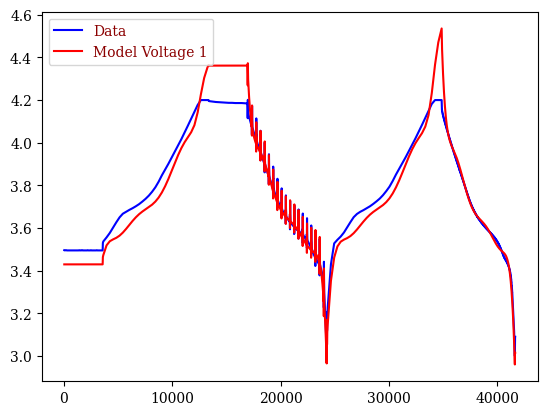

In [10]:
pt.plot_simultaneous_1("C", "01")


**Analysis**

We can observe that the model predicts the voltage in the pulse region better than the 0th order model. Indeed, the model now predicts exponential reaction of the battery.

The anomalies present in the 0th order are also present in the 1st order, which makes sense since parameters outside the pulse region are still not measured.

## **Error quantification and model improvement**

To evaluate the respective error of our models, 